In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from collections import OrderedDict, Counter
# from itertools import cycle
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from colormap import rgb2hex
# from scipy.integrate import cumtrapz
# from mpl_toolkits import mplot3d
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc

import tensorflow as tf
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.metrics import AUC, Recall, Precision

import logging
logging.disable(logging.WARNING)
logging.getLogger("tensorflow").setLevel(logging.ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ['AUTOGRAPH_VERBOSITY'] = '5'
tf.autograph.set_verbosity(0)

data_dir = '../data/processed_data'

In [2]:
activity = np.array([line.rstrip().split(' ') for line in open(os.path.join(data_dir,'activity_labels.txt'))])
activity = {int(k):v for k,v in zip(activity[:,0], activity[:,1])}

# Load data

In [3]:
with open('../data/processed_data/X.npy', 'rb') as f:
    X = np.load(f)
with open('../data/processed_data/y.npy', 'rb') as f:
    y = np.load(f)
df = pd.read_csv('../data/processed_data/data.csv',index_col=0)

print(X.shape, y.shape, df.shape)
df.head()

(10929, 128, 6) (10929,) (1122772, 11)


,ID,timestep,user ID,exp ID,accX,accY,accZ,gyroX,gyroY,gyroZ,label
0,0,0.00,1,1,0.918056,-0.112500,0.509722,-0.054978,-0.069639,-0.030849,-1
1,1,0.02,1,1,0.911111,-0.093056,0.537500,-0.012523,0.019242,-0.038485,-1
2,2,0.04,1,1,0.881944,-0.086111,0.513889,-0.023518,0.276417,0.006414,-1
3,3,0.06,1,1,0.881944,-0.086111,0.513889,-0.093462,0.367741,0.001222,-1
4,4,0.08,1,1,0.879167,-0.100000,0.505556,-0.124311,0.476780,-0.022907,-1


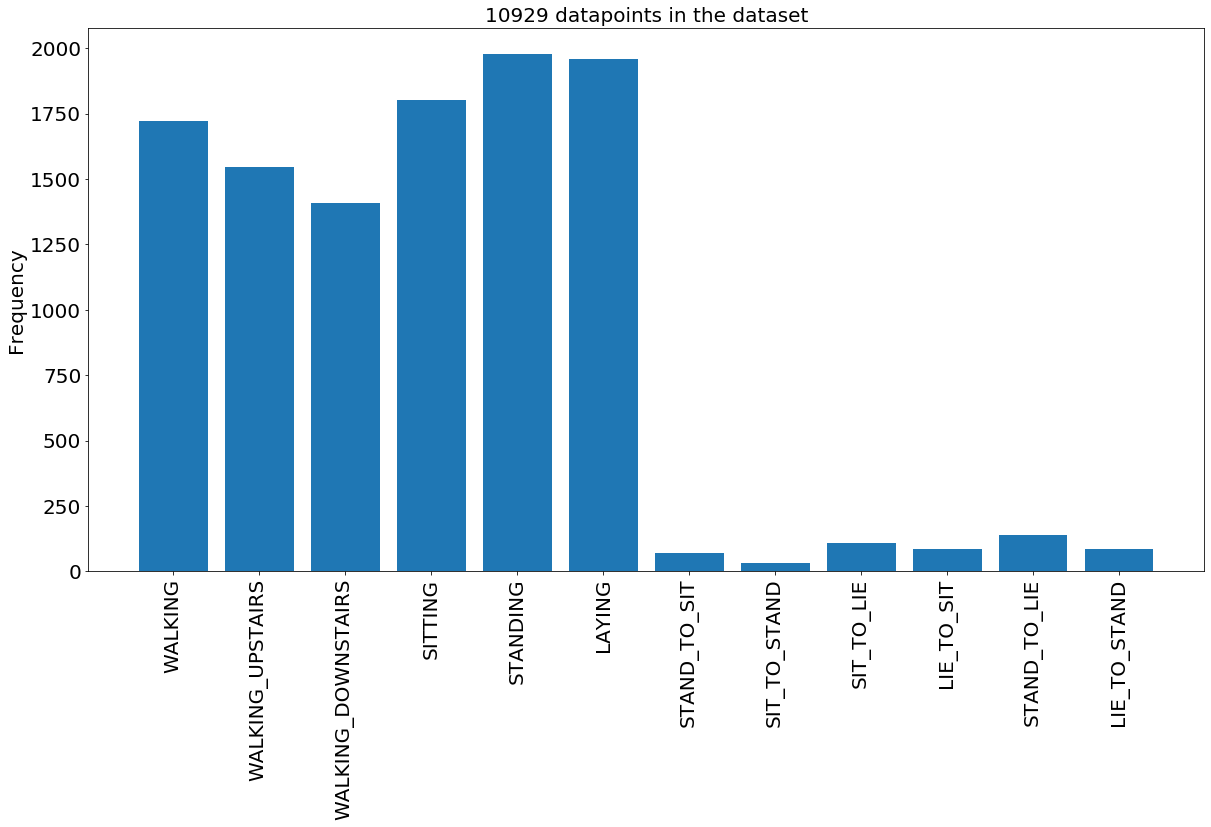

In [4]:
counts = Counter(y)

plt.figure(figsize=(20,10))
plt.bar(counts.keys(), counts.values(), width = 0.8)
plt.tick_params(labelsize = 20)
plt.xticks(list(counts.keys()), [activity[i] for i in list(counts.keys())],rotation=90)
plt.ylabel("Frequency",fontsize=20)
plt.title('%s datapoints in the dataset'%(y.shape[0]),fontsize=20)

plt.show()

# Data visualization
## User 1 - experience 1

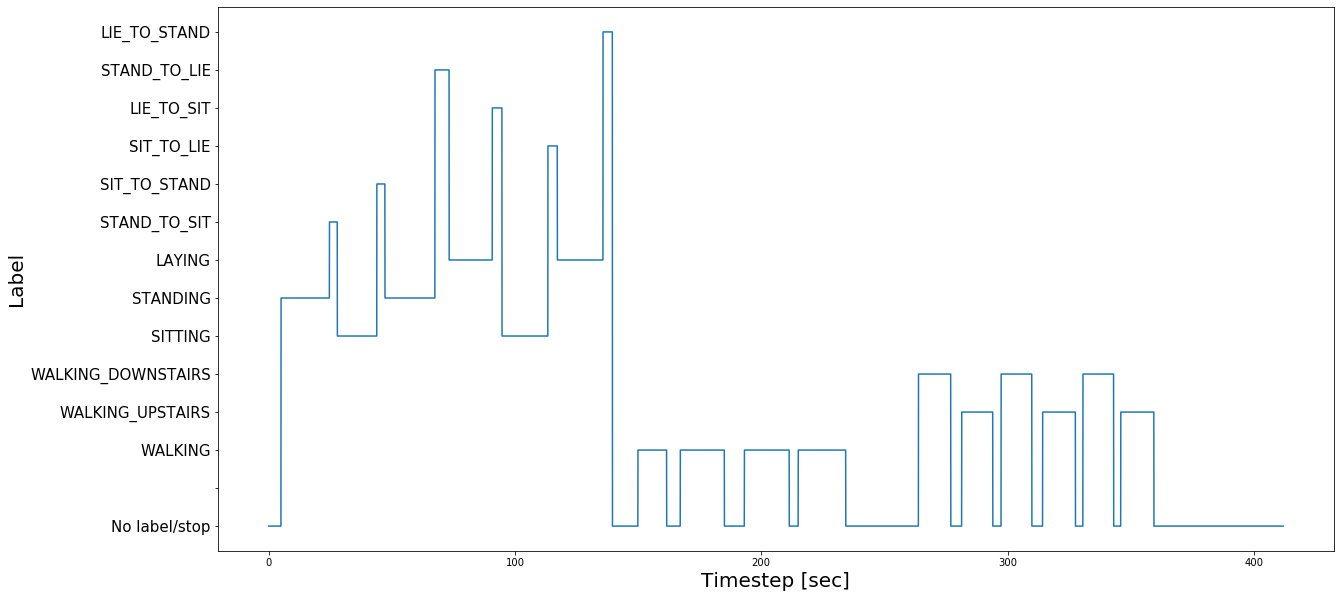

In [5]:
vis = df[(df['user ID']==1) & (df['exp ID']==1)]

plt.figure(figsize=(20,10))
plt.plot(vis['timestep'], vis['label'])
plt.xlabel('Timestep [sec]', fontsize=20)
plt.ylabel('Label', fontsize=20)
plt.yticks(np.arange(-1,len(list(activity.values()))+1), ['No label/stop', ''] + list(activity.values()), fontsize=15)

plt.show()

# Dataset creation

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y-1, test_size=0.25, random_state=0, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=0, stratify=y_val)

In [7]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

# RNN - LSTM approach

In [8]:
def recall_m(y_true, y_pred):
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return TP / (Positives+K.epsilon())
    
def precision_m(y_true, y_pred):
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return TP / (Pred_Positives+K.epsilon()) 

def f1_score_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [9]:
callbacks_list = [EarlyStopping(patience=20),
                  ModelCheckpoint(filepath='../model/model.{epoch:02d}-{val_loss:.2f}.h5', 
                                  save_best_only=True,
                                  monitor='val_loss',
                                  mode='min'),
                  ReduceLROnPlateau(monitor='val_loss',
                                    factor=0.2,
                                    patience=5,
                                    min_lr=0.001)]
metrics = [precision_m,
           recall_m,
           f1_score_m]

In [10]:
step = 128 # 2.56 sec at 50 Hz - sliding window
num_features = 6 # X-Y-Z for acc and gyro
num_classes = len(np.unique(y)) # 12 labels

In [11]:
model = Sequential()
model.add(LSTM(100, input_shape=(step, num_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)

# Model training

In [12]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=64,
                    callbacks=callbacks_list,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    verbose=0)

# Model evaluation

In [13]:
results = model.evaluate(X_test, y_test, verbose=2)

43/43 - 1s - loss: 0.2260 - precision_m: 0.9276 - recall_m: 0.9249 - f1_score_m: 0.9262 - 741ms/epoch - 17ms/step


# Training metrics

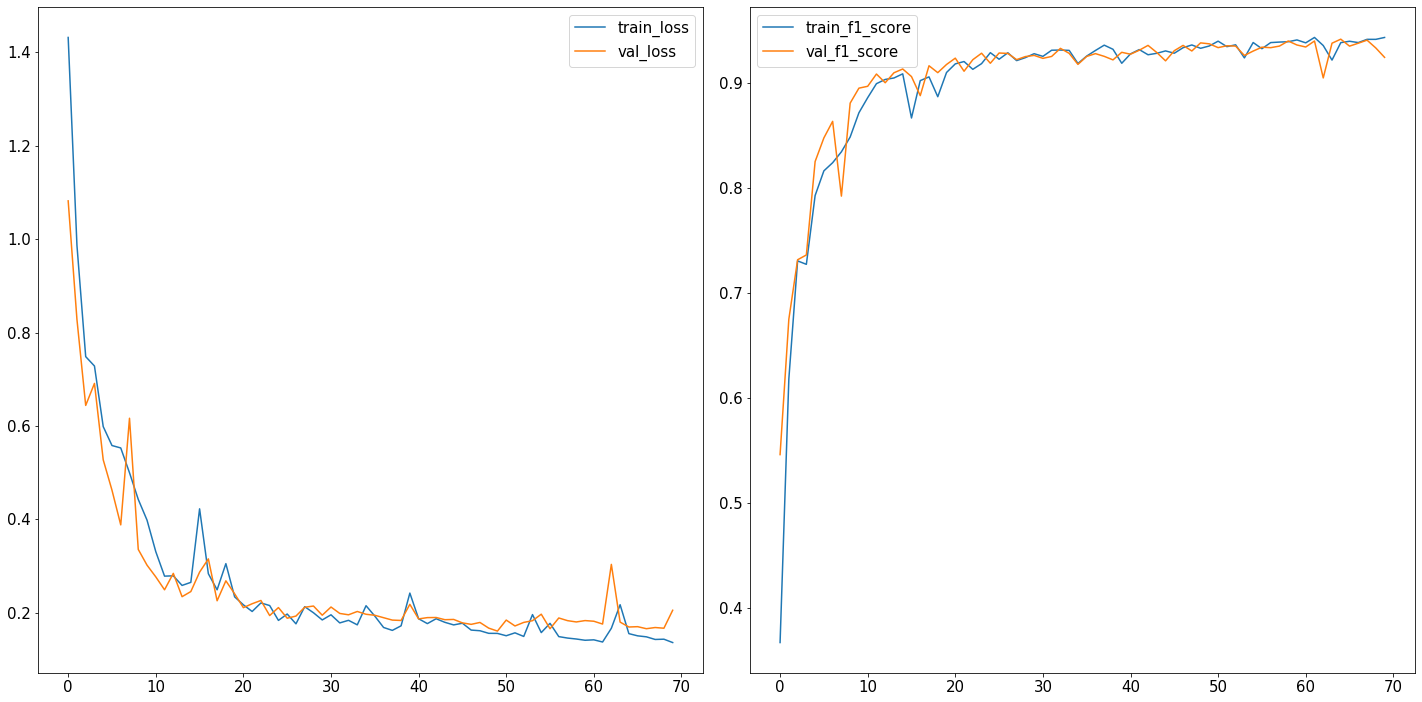

In [14]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 15})

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['f1_score_m'], label='train_f1_score')
plt.plot(history.history['val_f1_score_m'], label='val_f1_score')
plt.legend()

plt.tight_layout()

# Test data evaluation

In [15]:
preds = model.predict(X_test)

### ROC

In [16]:
n_classes = len(list(activity.values()))
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

### Confusion matrix

In [17]:
res = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(preds,axis=1))
col = [i.lower() for i in list(activity.values())]
confusion = pd.DataFrame(res, columns=col, index = col)
confusion.index.name, confusion.columns.name = 'Actual', 'Predicted'

### Plot results

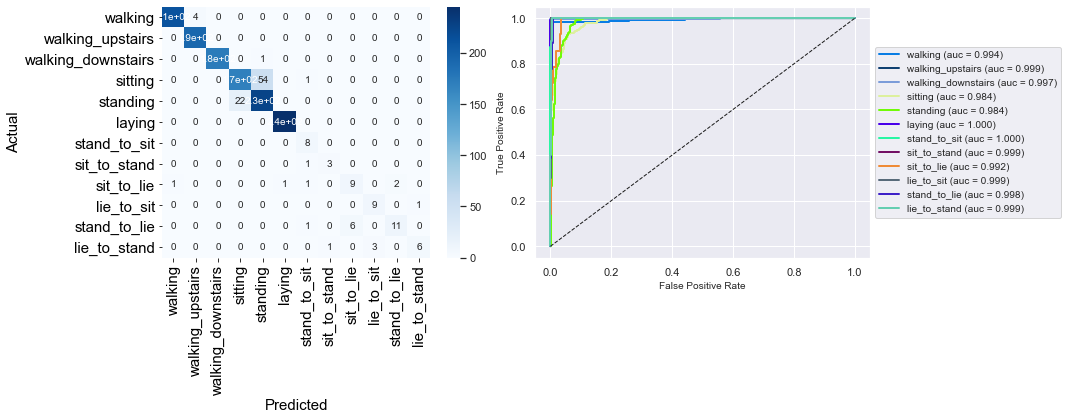

In [18]:
plt.figure(figsize = (15,6))
plt.subplot(1,2,1)
sns.set(font_scale=1)
sns.heatmap(confusion, annot=True, cmap='Blues', annot_kws={"size": 10})

plt.subplot(1,2,2)
np.random.seed(10)
colors = [(np.random.choice(range(256), size=3)).tolist() for i in range(n_classes)]
for idx in range(n_classes):
    plt.plot(fpr[idx],tpr[idx],
             color=rgb2hex(*colors[idx]),
             lw=2,
             label="{0} (auc = {1:0.3f})".format(activity[idx+1].lower(), roc_auc[idx]))
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate", fontsize=10)
plt.ylabel("True Positive Rate", fontsize=10)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.tight_layout()
plt.show()